In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setting color scheme for graphs
colors = ["#FF7D00", "#FFDD00", "#FF006D", "#8F00FF", "#01BEFE", "#8cff00"]
sns.set_palette(sns.color_palette(colors))

In [2]:
# Setting URL and selecting tickers
finviz_quotes = 'https://finviz.com/quote.ashx?t='
tickers = ['TSLA', 'AMZN', 'FB']    

In [3]:
# Scraping data from Finviz
stock_headlines = {}
for ticker in tickers:
    url = finviz_quotes + ticker
    req = Request(url = url, headers = {'user-agent': 'my-app'})
    res = urlopen(req)
    
    # Fetching from target html elements
    html = BeautifulSoup(res, features = 'html')
    stock_headline = html.find(id = 'news-table')
    stock_headlines[ticker] = stock_headline

In [4]:
# Parsing and aggregating data
parsed_data = []
for ticker, news in stock_headlines.items():
    for row in news.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')
        
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        
        parsed_data.append([ticker, date, time, title])
        
df = pd.DataFrame(parsed_data, columns = ['ticker', 'date', 'time', 'title'])

In [5]:
# Using NLTK's Vader to run Sentiment Analysis
vader = SentimentIntensityAnalyzer()

# Test output for Vader 
print(vader.polarity_scores("A Week of Mayhem in China Stocks Exposes Global Index Fund Risks"))

{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.3818}


In [6]:
# Applying Vader on news titles using lambda function to get compound score
f = lambda title: vader.polarity_scores(title)['compound']

# Collecting compound results, view date-time to visualize trend over time
df['compound'] = df['title'].apply(f)
df['date'] = pd.to_datetime(df.date).dt.date
df

,ticker,date,time,title,compound
0,TSLA,2021-07-30,04:30PM,Stock Market Rally Pauses Near Highs Amid Earn...,0.1779
1,TSLA,2021-07-30,04:18PM,"Dow Jones Dips, Amazon Stock Plunges Amid Reco...",0.3612
2,TSLA,2021-07-30,03:59PM,Is Nio Stock A Buy After Q2 Sales More Than Do...,0.0000
3,TSLA,2021-07-30,03:50PM,Why Nio Stock Popped Friday,0.0000
4,TSLA,2021-07-30,03:46PM,Elon Musk Slams Apples App Store Fees as De Fa...,0.0000
...,...,...,...,...,...
295,FB,2021-07-27,08:00AM,"Here's Who Wins In Apple, Microsoft, Amazon, A...",0.8074
296,FB,2021-07-27,07:00AM,"Forget Facebook, This Could Be the Best Social...",0.5106
297,FB,2021-07-27,06:40AM,Facebook Wants to Dominate Virtual Reality,-0.1280
298,FB,2021-07-27,06:07AM,"Google, Facebook set to squash initial iOS fea...",-0.4215


<Figure size 792x576 with 0 Axes>

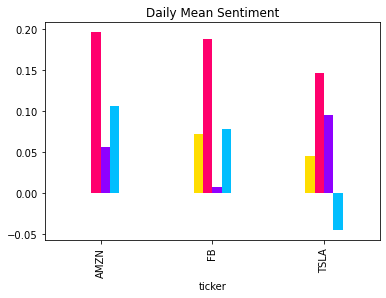

In [7]:
# Plotting daily average compound scores 
plt.figure(figsize=(11,8))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
mean_df = mean_df.xs('compound', axis = "columns")
mean_df.plot(kind = 'bar', legend = None, title = 'Daily Mean Sentiment')
plt.show()

In [8]:
# Aggregating all headlines
stocks_news = df['title'].str.cat(sep=' ')

In [9]:
# Fetching company names from tickers
mw_quotes = 'https://www.marketwatch.com/investing/stock/'
companies = []
for ticker in tickers:
    url = mw_quotes + ticker
    req = Request(url = url, headers = {'user-agent': 'my-app'})
    res = urlopen(req)
    
    # Fetching company names
    html = BeautifulSoup(res, features = 'html')
    company = html.find('h1').text.strip().split(' ')[0].split('.')[0]
    companies.append(company)

In [10]:
# Updating stop-words to filter from word cloud
new_stopwords = companies + ['stock', 'stocks']
STOPWORDS.update(new_stopwords)
stocks_cloud = WordCloud(stopwords = STOPWORDS, background_color="white").generate(stocks_news)

In [11]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (11, 8))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

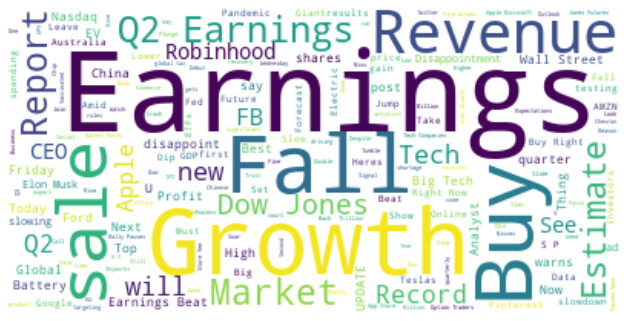

In [12]:
show_word_cloud(stocks_cloud, '')